manually install torch with cuda:
```terminal
pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
```

In [28]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.amp import autocast, GradScaler
import torch.nn.functional as F
import copy
import numpy as np
import optuna
import time
import itertools
import pandas as pd

import optuna

### PyTorch with CUDA

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
print("Using device:", device)

Using device: cuda:0


### Get CIFAR10 data

In [30]:
TRAINING_SIZE = 5000    #! old value: 49000
VALIDATION_SIZE = 1000  #! old value: 1000
BATCH_SIZE = 512
NUM_WORKERS = 12

iters_per_epoch = np.ceil(TRAINING_SIZE / BATCH_SIZE)

RANDOM_SEED = 0
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [31]:
transform_train = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_val_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

cifar10_train = dset.CIFAR10('datasets', train=True, download=True, transform=transform_train)
# cifar10_val = dset.CIFAR10('datasets', train=True, download=True, transform=transform_val_test)
cifar10_test = dset.CIFAR10('datasets', train=False, download=True, transform=transform_val_test)

indices = np.arange(len(cifar10_train))
np.random.shuffle(indices)
train_idx = indices[:TRAINING_SIZE]
val_idx = indices[TRAINING_SIZE:TRAINING_SIZE + VALIDATION_SIZE]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

loader_train = DataLoader(
    cifar10_train,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True
)

loader_val = DataLoader(
    cifar10_train,
    batch_size=BATCH_SIZE,
    sampler=val_sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True
)

print(f"Train batches: {len(loader_train)}, Val batches: {len(loader_val)}")
print(f"Results in {iters_per_epoch} iterations per epoch.")

Train batches: 10, Val batches: 2
Results in 10.0 iterations per epoch.


### Model and Hyperparameter Training

In [32]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    num_epochs=10,
    criterion=None,
    device=None,
    print_every=20,
    patience=3,
    accumulation_steps=1,
    scheduler=None
):
    """
    Optimized training function with AMP, early stopping, gradient accumulation, 
    best model saving, and optional scheduler.
    """
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    criterion = criterion or F.cross_entropy
    optimizer = optimizer
    scaler = GradScaler()

    best_val_acc = -float('inf')
    best_model = None
    epochs_no_improve = 0

    train_accs, val_accs, lrs, epoch_times = [], [], [], []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad() if accumulation_steps == 1 else None

            with autocast("cuda"):
                outputs = model(x)
                loss = criterion(outputs, y) / accumulation_steps  # scale loss for accumulation

            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            running_loss += loss.item() * accumulation_steps
            if (i + 1) % print_every == 0:
                print(f"Epoch {epoch+1}, Iter {i+1}, Avg Loss: {running_loss/print_every:.4f}")
                running_loss = 0.0

        # Step scheduler at epoch end
        if scheduler is not None:
            scheduler.step()
            lrs.append(scheduler.get_last_lr()[0])

        # Validation check
        val_acc = get_accuracy(val_loader, model, f"Validation Epoch {epoch+1}", device)
        val_accs.append(val_acc)
        
        train_acc = get_accuracy(train_loader, model, f"Training Epoch {epoch+1}", device=device)
        train_accs.append(train_acc)

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = copy.deepcopy(model)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    total_time = time.time() - start_time

    return {
        "model": best_model if best_model else model,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "lrs": lrs,
        "epoch_times": epoch_times,
        "total_time": total_time
    }


def get_accuracy(loader, model, name="Validation", device=device, debug=True):
    """
    Compute accuracy of the model on a given DataLoader.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            with autocast("cuda"):
                scores = model(x)
            preds = scores.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = correct / total
    if debug:
        print(f"{name} Accuracy: {100*acc:.2f}%")
    return acc

In [33]:
def hyperparam_training(learn_rate, epochs):

    ch1 = 16
    ch2 = 64
    ch3 = 32
    model = nn.Sequential(
        nn.Conv2d(3, ch1, 5, padding=2),
        nn.BatchNorm2d(ch1),
        nn.ReLU(),

        nn.Conv2d(ch1, ch2, 3, padding=1),
        nn.BatchNorm2d(ch2),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(ch2, ch3, 3, padding=1),
        nn.BatchNorm2d(ch3),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Flatten(),
        nn.Linear(ch3 * 8 * 8, 128),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(128, 10)
    ).to(device)

    weight_decay = 2.075612963823467e-06
    optimizer = torch.optim.AdamW(model.parameters(), lr=learn_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    training_result = train_model(
        model=model,
        train_loader=loader_train,
        val_loader=loader_val,
        num_epochs=epochs,
        device=device,
        print_every=len(loader_train) // 4,
        patience=2,
        optimizer=optimizer,
        scheduler=scheduler,
    )
    trained_model = training_result["model"]
    
    val_acc = get_accuracy(loader_val, trained_model, device=device, debug=False)

    return {
        "lr": learn_rate,
        "epochs": epochs,
        "val_acc": val_acc,
        "train_accs": training_result["train_accs"],
        "val_accs": training_result["val_accs"],
        "runtime": training_result["total_time"],
    }

## Search Algorithms

In [34]:
NUM_TRIALS = 25
NUM_PER_DIM = np.sqrt(NUM_TRIALS).astype(int)
LR_MIN = 1e-6
LR_MAX = 1e-2
EPOCHS_MIN = 5
EPOCHS_MAX = 25

print(f"{NUM_TRIALS} trials will be run, {NUM_PER_DIM} per dimension.")

25 trials will be run, 5 per dimension.


### Hidden Results

In [73]:
HIDDEN_TRIALS = 200
HIDDEN_TESTS_PER_DIM = np.sqrt(HIDDEN_TRIALS).astype(int)

def run_hidden_results():
    lr_values = np.logspace(np.log10(LR_MIN), np.log10(LR_MAX), HIDDEN_TESTS_PER_DIM)
    epochs_values = np.linspace(EPOCHS_MIN, EPOCHS_MAX, HIDDEN_TESTS_PER_DIM, dtype=int)

    results = []
    counter = 1
    for lr, ep in itertools.product(lr_values, epochs_values):
        print(f"\n[Grid {counter}/{HIDDEN_TRIALS}] lr={lr:.3e}, epochs={ep}")
        res = hyperparam_training(lr, ep)
        res["counter"] = counter
        res["search"] = "grid"
        results.append(res)
        counter += 1

    return pd.DataFrame(results)

### Grid Search

In [ ]:
def run_grid_search():
    lr_values = np.logspace(np.log10(LR_MIN), np.log10(LR_MAX), NUM_PER_DIM)
    epochs_values = np.linspace(EPOCHS_MIN, EPOCHS_MAX, NUM_PER_DIM, dtype=int)

    results = []
    counter = 1
    for lr, ep in itertools.product(lr_values, epochs_values):
        print(f"\n[Grid {counter}/{NUM_PER_DIM}] lr={lr:.3e}, epochs={ep}")
        res = hyperparam_training(lr, ep)
        res["counter"] = counter
        res["search"] = "grid"
        results.append(res)
        counter += 1

    return pd.DataFrame(results)

### Random Search

In [72]:
def run_random_search():
    lr_values = 10 ** np.random.uniform(np.log10(LR_MIN), np.log10(LR_MAX), NUM_TRIALS)
    epochs_values = np.random.randint(EPOCHS_MIN, EPOCHS_MAX+1, NUM_TRIALS)

    results = []
    counter = 1
    for lr, ep in zip(lr_values, epochs_values):
        print(f"\n[Random {counter}/{NUM_TRIALS}] lr={lr:.3e}, epochs={ep}")
        res = hyperparam_training(lr, ep)
        res["counter"] = counter
        res["search"] = "random"
        results.append(res)
        counter += 1
        
    return pd.DataFrame(results)

### Bayesian Search

In [38]:
def objective(trial):
    lr = trial.suggest_float("learn_rate", LR_MIN, LR_MAX, log=True)
    epochs = trial.suggest_int("epochs", EPOCHS_MIN, EPOCHS_MAX)

    results = hyperparam_training(lr, epochs)
    return results["val_acc"]

In [39]:
def run_bayesian_search():
    study_name = "bayesian_optimization"
    storage_name = f"sqlite:///{study_name}.db"

    # Reset study
    summaries = optuna.study.get_all_study_summaries(storage=storage_name)
    if study_name in [s.study_name for s in summaries]:
        optuna.delete_study(study_name=study_name, storage=storage_name)
        print(f"Deleted existing study: {study_name}")

    study = optuna.create_study(
        study_name=study_name,
        storage=storage_name,
        direction="maximize",
    )

    study.optimize(objective, n_trials=NUM_TRIALS)

    rows = []
    for t in study.trials:
        row = {
            "counter": t.number + 1,
            "lr": t.params.get("learn_rate", None),
            "epochs": t.params.get("epochs", None),
            "val_acc": t.value,
            "search": "bayesian"
        }
        # todo: get time for each trial.
        rows.append(row)

    return pd.DataFrame(rows)

## Results

In [ ]:
df_hidden = run_hidden_results()
df_hidden.to_csv("results/hidden.csv")


[Grid 1/25] lr=1.000e-06, epochs=5
Epoch 1, Iter 2, Avg Loss: 2.3338
Epoch 1, Iter 4, Avg Loss: 2.3141
Epoch 1, Iter 6, Avg Loss: 2.3327
Epoch 1, Iter 8, Avg Loss: 2.3239
Epoch 1, Iter 10, Avg Loss: 2.3298
Validation Epoch 1 Accuracy: 12.50%
Training Epoch 1 Accuracy: 14.02%
Epoch 2, Iter 2, Avg Loss: 2.3235
Epoch 2, Iter 4, Avg Loss: 2.3187
Epoch 2, Iter 6, Avg Loss: 2.3429
Epoch 2, Iter 8, Avg Loss: 2.3174
Epoch 2, Iter 10, Avg Loss: 2.3338
Validation Epoch 2 Accuracy: 12.30%
Training Epoch 2 Accuracy: 13.22%
Epoch 3, Iter 2, Avg Loss: 2.3358
Epoch 3, Iter 4, Avg Loss: 2.2999
Epoch 3, Iter 6, Avg Loss: 2.3029
Epoch 3, Iter 8, Avg Loss: 2.3228
Epoch 3, Iter 10, Avg Loss: 2.3165
Validation Epoch 3 Accuracy: 14.00%
Training Epoch 3 Accuracy: 13.06%
Epoch 4, Iter 2, Avg Loss: 2.3191
Epoch 4, Iter 4, Avg Loss: 2.3099
Epoch 4, Iter 6, Avg Loss: 2.3197
Epoch 4, Iter 8, Avg Loss: 2.3102
Epoch 4, Iter 10, Avg Loss: 2.3230
Validation Epoch 4 Accuracy: 13.60%
Training Epoch 4 Accuracy: 13.04%


In [55]:

#! combine this with cell above next time

df_grid = run_grid_search()
df_grid.to_csv("results/grid.csv")


[Grid 1/25] lr=1.000e-06, epochs=5
Epoch 1, Iter 2, Avg Loss: 2.3309
Epoch 1, Iter 4, Avg Loss: 2.3178
Epoch 1, Iter 6, Avg Loss: 2.3336
Epoch 1, Iter 8, Avg Loss: 2.3334
Epoch 1, Iter 10, Avg Loss: 2.3262
Validation Epoch 1 Accuracy: 10.80%
Training Epoch 1 Accuracy: 11.34%
Epoch 2, Iter 2, Avg Loss: 2.3205
Epoch 2, Iter 4, Avg Loss: 2.3284
Epoch 2, Iter 6, Avg Loss: 2.3329
Epoch 2, Iter 8, Avg Loss: 2.3270
Epoch 2, Iter 10, Avg Loss: 2.3292
Validation Epoch 2 Accuracy: 11.40%
Training Epoch 2 Accuracy: 11.56%
Epoch 3, Iter 2, Avg Loss: 2.3171
Epoch 3, Iter 4, Avg Loss: 2.3200
Epoch 3, Iter 6, Avg Loss: 2.3200
Epoch 3, Iter 8, Avg Loss: 2.3222
Epoch 3, Iter 10, Avg Loss: 2.3201
Validation Epoch 3 Accuracy: 12.20%
Training Epoch 3 Accuracy: 10.94%
Epoch 4, Iter 2, Avg Loss: 2.3215
Epoch 4, Iter 4, Avg Loss: 2.3203
Epoch 4, Iter 6, Avg Loss: 2.3200
Epoch 4, Iter 8, Avg Loss: 2.3194
Epoch 4, Iter 10, Avg Loss: 2.3034
Validation Epoch 4 Accuracy: 10.80%
Training Epoch 4 Accuracy: 10.54%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001D44D462520>
Traceback (most recent call last):
  File "c:\Users\Jax\Coding\Optimierungsverfahren\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "c:\Users\Jax\Coding\Optimierungsverfahren\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1577, in _shutdown_workers
    self._mark_worker_as_unavailable(worker_id, shutdown=True)
  File "c:\Users\Jax\Coding\Optimierungsverfahren\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1513, in _mark_worker_as_unavailable
    assert self._workers_status[worker_id] or (
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Training Epoch 3 Accuracy: 29.84%
Epoch 4, Iter 2, Avg Loss: 1.9467
Epoch 4, Iter 4, Avg Loss: 1.9757
Epoch 4, Iter 6, Avg Loss: 1.9576
Epoch 4, Iter 8, Avg Loss: 1.9507
Epoch 4, Iter 10, Avg Loss: 1.9600
Validation Epoch 4 Accuracy: 30.80%
Training Epoch 4 Accuracy: 33.68%
Epoch 5, Iter 2, Avg Loss: 1.8995
Epoch 5, Iter 4, Avg Loss: 1.9165
Epoch 5, Iter 6, Avg Loss: 1.8843
Epoch 5, Iter 8, Avg Loss: 1.8851
Epoch 5, Iter 10, Avg Loss: 1.8894
Validation Epoch 5 Accuracy: 35.20%
Training Epoch 5 Accuracy: 36.26%
Epoch 6, Iter 2, Avg Loss: 1.8713
Epoch 6, Iter 4, Avg Loss: 1.8996
Epoch 6, Iter 6, Avg Loss: 1.8503
Epoch 6, Iter 8, Avg Loss: 1.8290
Epoch 6, Iter 10, Avg Loss: 1.8027
Validation Epoch 6 Accuracy: 35.80%
Training Epoch 6 Accuracy: 36.44%
Epoch 7, Iter 2, Avg Loss: 1.8254
Epoch 7, Iter 4, Avg Loss: 1.8632
Epoch 7, Iter 6, Avg Loss: 1.8646
Epoch 7, Iter 8, Avg Loss: 1.7775
Epoch 7, Iter 10, Avg Loss: 1.7826
Validation Epoch 7 Accuracy: 36.10%
Training Epoch 7 Accuracy: 38.66%
Ep

In [74]:
df_random = run_random_search()
df_random.to_csv("results/random.csv")

#! combine this with cell above next time

# df_bayesian = run_bayesian_search()
# df_bayesian.to_csv("results/bayesian.csv")


[Random 1/25] lr=4.824e-06, epochs=6
Epoch 1, Iter 2, Avg Loss: 2.3350
Epoch 1, Iter 4, Avg Loss: 2.3512
Epoch 1, Iter 6, Avg Loss: 2.3294
Epoch 1, Iter 8, Avg Loss: 2.3252
Epoch 1, Iter 10, Avg Loss: 2.3337
Validation Epoch 1 Accuracy: 11.40%
Training Epoch 1 Accuracy: 10.36%
Epoch 2, Iter 2, Avg Loss: 2.3301
Epoch 2, Iter 4, Avg Loss: 2.3255
Epoch 2, Iter 6, Avg Loss: 2.3228
Epoch 2, Iter 8, Avg Loss: 2.3213
Epoch 2, Iter 10, Avg Loss: 2.3136
Validation Epoch 2 Accuracy: 10.60%
Training Epoch 2 Accuracy: 10.88%
Epoch 3, Iter 2, Avg Loss: 2.3156
Epoch 3, Iter 4, Avg Loss: 2.3165
Epoch 3, Iter 6, Avg Loss: 2.3192
Epoch 3, Iter 8, Avg Loss: 2.3216
Epoch 3, Iter 10, Avg Loss: 2.2986
Validation Epoch 3 Accuracy: 12.00%
Training Epoch 3 Accuracy: 11.40%
Epoch 4, Iter 2, Avg Loss: 2.3169
Epoch 4, Iter 4, Avg Loss: 2.3152
Epoch 4, Iter 6, Avg Loss: 2.3141
Epoch 4, Iter 8, Avg Loss: 2.3023
Epoch 4, Iter 10, Avg Loss: 2.3085
Validation Epoch 4 Accuracy: 11.60%
Training Epoch 4 Accuracy: 11.00

In [84]:

#! combine this with cell above next time

df_bayesian = run_bayesian_search()
df_bayesian.to_csv("results/bayesian.csv")

[I 2025-12-01 00:38:42,442] A new study created in RDB with name: bayesian_optimization


Deleted existing study: bayesian_optimization
Epoch 1, Iter 2, Avg Loss: 2.3374
Epoch 1, Iter 4, Avg Loss: 2.3367
Epoch 1, Iter 6, Avg Loss: 2.3370
Epoch 1, Iter 8, Avg Loss: 2.3245
Epoch 1, Iter 10, Avg Loss: 2.3289
Validation Epoch 1 Accuracy: 8.40%
Training Epoch 1 Accuracy: 9.60%
Epoch 2, Iter 2, Avg Loss: 2.3162
Epoch 2, Iter 4, Avg Loss: 2.3225
Epoch 2, Iter 6, Avg Loss: 2.3264
Epoch 2, Iter 8, Avg Loss: 2.3117
Epoch 2, Iter 10, Avg Loss: 2.3205
Validation Epoch 2 Accuracy: 10.20%
Training Epoch 2 Accuracy: 10.02%
Epoch 3, Iter 2, Avg Loss: 2.3091
Epoch 3, Iter 4, Avg Loss: 2.3125
Epoch 3, Iter 6, Avg Loss: 2.3151
Epoch 3, Iter 8, Avg Loss: 2.3093
Epoch 3, Iter 10, Avg Loss: 2.2999
Validation Epoch 3 Accuracy: 11.10%
Training Epoch 3 Accuracy: 11.64%
Epoch 4, Iter 2, Avg Loss: 2.2899
Epoch 4, Iter 4, Avg Loss: 2.2973
Epoch 4, Iter 6, Avg Loss: 2.3000
Epoch 4, Iter 8, Avg Loss: 2.2791
Epoch 4, Iter 10, Avg Loss: 2.2844
Validation Epoch 4 Accuracy: 13.30%
Training Epoch 4 Accuracy:

[I 2025-12-01 00:38:47,883] Trial 0 finished with value: 0.141 and parameters: {'learn_rate': 5.1644759858707125e-06, 'epochs': 11}. Best is trial 0 with value: 0.141.


Epoch 1, Iter 2, Avg Loss: 3.0359
Epoch 1, Iter 4, Avg Loss: 3.1757
Epoch 1, Iter 6, Avg Loss: 2.4305
Epoch 1, Iter 8, Avg Loss: 2.1955
Epoch 1, Iter 10, Avg Loss: 2.0724
Validation Epoch 1 Accuracy: 23.50%
Training Epoch 1 Accuracy: 24.02%
Epoch 2, Iter 2, Avg Loss: 2.0245
Epoch 2, Iter 4, Avg Loss: 2.0446
Epoch 2, Iter 6, Avg Loss: 1.9827
Epoch 2, Iter 8, Avg Loss: 1.9669
Epoch 2, Iter 10, Avg Loss: 1.9725
Validation Epoch 2 Accuracy: 26.70%
Training Epoch 2 Accuracy: 28.50%
Epoch 3, Iter 2, Avg Loss: 1.9518
Epoch 3, Iter 4, Avg Loss: 1.9077
Epoch 3, Iter 6, Avg Loss: 1.9037
Epoch 3, Iter 8, Avg Loss: 1.8962
Epoch 3, Iter 10, Avg Loss: 1.8614
Validation Epoch 3 Accuracy: 29.80%
Training Epoch 3 Accuracy: 32.50%
Epoch 4, Iter 2, Avg Loss: 1.8435
Epoch 4, Iter 4, Avg Loss: 1.8554
Epoch 4, Iter 6, Avg Loss: 1.8045
Epoch 4, Iter 8, Avg Loss: 1.7491
Epoch 4, Iter 10, Avg Loss: 1.7448
Validation Epoch 4 Accuracy: 33.10%
Training Epoch 4 Accuracy: 35.90%
Epoch 5, Iter 2, Avg Loss: 1.7515
Ep

[I 2025-12-01 00:38:53,357] Trial 1 finished with value: 0.409 and parameters: {'learn_rate': 0.0026297435968120537, 'epochs': 9}. Best is trial 1 with value: 0.409.


Training Epoch 9 Accuracy: 42.96%
Early stopping triggered after 9 epochs.
Epoch 1, Iter 2, Avg Loss: 2.3367
Epoch 1, Iter 4, Avg Loss: 2.3260
Epoch 1, Iter 6, Avg Loss: 2.3318
Epoch 1, Iter 8, Avg Loss: 2.3158
Epoch 1, Iter 10, Avg Loss: 2.3094
Validation Epoch 1 Accuracy: 13.30%
Training Epoch 1 Accuracy: 11.16%
Epoch 2, Iter 2, Avg Loss: 2.3189
Epoch 2, Iter 4, Avg Loss: 2.3175
Epoch 2, Iter 6, Avg Loss: 2.3257
Epoch 2, Iter 8, Avg Loss: 2.3235
Epoch 2, Iter 10, Avg Loss: 2.3185
Validation Epoch 2 Accuracy: 10.80%
Training Epoch 2 Accuracy: 10.84%
Epoch 3, Iter 2, Avg Loss: 2.3332
Epoch 3, Iter 4, Avg Loss: 2.3116
Epoch 3, Iter 6, Avg Loss: 2.3291
Epoch 3, Iter 8, Avg Loss: 2.3267
Epoch 3, Iter 10, Avg Loss: 2.3287
Validation Epoch 3 Accuracy: 12.20%
Training Epoch 3 Accuracy: 11.26%
Early stopping triggered after 3 epochs.


[I 2025-12-01 00:38:55,388] Trial 2 finished with value: 0.133 and parameters: {'learn_rate': 1.5308633224723892e-06, 'epochs': 5}. Best is trial 1 with value: 0.409.


Epoch 1, Iter 2, Avg Loss: 2.4494
Epoch 1, Iter 4, Avg Loss: 2.2329
Epoch 1, Iter 6, Avg Loss: 2.1597
Epoch 1, Iter 8, Avg Loss: 2.0396
Epoch 1, Iter 10, Avg Loss: 1.9922
Validation Epoch 1 Accuracy: 28.10%
Training Epoch 1 Accuracy: 29.76%
Epoch 2, Iter 2, Avg Loss: 1.9637
Epoch 2, Iter 4, Avg Loss: 1.9345
Epoch 2, Iter 6, Avg Loss: 1.8775
Epoch 2, Iter 8, Avg Loss: 1.9038
Epoch 2, Iter 10, Avg Loss: 1.8791
Validation Epoch 2 Accuracy: 31.20%
Training Epoch 2 Accuracy: 32.42%
Epoch 3, Iter 2, Avg Loss: 1.8451
Epoch 3, Iter 4, Avg Loss: 1.8670
Epoch 3, Iter 6, Avg Loss: 1.7722
Epoch 3, Iter 8, Avg Loss: 1.7931
Epoch 3, Iter 10, Avg Loss: 1.6841
Validation Epoch 3 Accuracy: 35.20%
Training Epoch 3 Accuracy: 36.36%
Epoch 4, Iter 2, Avg Loss: 1.7474
Epoch 4, Iter 4, Avg Loss: 1.6916
Epoch 4, Iter 6, Avg Loss: 1.6938
Epoch 4, Iter 8, Avg Loss: 1.6635
Epoch 4, Iter 10, Avg Loss: 1.7025
Validation Epoch 4 Accuracy: 37.60%
Training Epoch 4 Accuracy: 38.74%
Epoch 5, Iter 2, Avg Loss: 1.6670
Ep

[I 2025-12-01 00:38:59,101] Trial 3 finished with value: 0.396 and parameters: {'learn_rate': 0.0017359725575441154, 'epochs': 6}. Best is trial 1 with value: 0.409.


Training Epoch 6 Accuracy: 42.18%
Epoch 1, Iter 2, Avg Loss: 2.3308
Epoch 1, Iter 4, Avg Loss: 2.2754
Epoch 1, Iter 6, Avg Loss: 2.2504
Epoch 1, Iter 8, Avg Loss: 2.1951
Epoch 1, Iter 10, Avg Loss: 2.1752
Validation Epoch 1 Accuracy: 20.30%
Training Epoch 1 Accuracy: 19.48%
Epoch 2, Iter 2, Avg Loss: 2.1473
Epoch 2, Iter 4, Avg Loss: 2.1046
Epoch 2, Iter 6, Avg Loss: 2.0804
Epoch 2, Iter 8, Avg Loss: 2.0022
Epoch 2, Iter 10, Avg Loss: 1.9838
Validation Epoch 2 Accuracy: 30.50%
Training Epoch 2 Accuracy: 29.26%
Epoch 3, Iter 2, Avg Loss: 1.9851
Epoch 3, Iter 4, Avg Loss: 1.9280
Epoch 3, Iter 6, Avg Loss: 1.9441
Epoch 3, Iter 8, Avg Loss: 1.9313
Epoch 3, Iter 10, Avg Loss: 1.9030
Validation Epoch 3 Accuracy: 33.20%
Training Epoch 3 Accuracy: 33.44%
Epoch 4, Iter 2, Avg Loss: 1.9055
Epoch 4, Iter 4, Avg Loss: 1.8494
Epoch 4, Iter 6, Avg Loss: 1.8561
Epoch 4, Iter 8, Avg Loss: 1.8365
Epoch 4, Iter 10, Avg Loss: 1.8444
Validation Epoch 4 Accuracy: 35.00%
Training Epoch 4 Accuracy: 36.50%
Ep

[I 2025-12-01 00:39:05,230] Trial 4 finished with value: 0.398 and parameters: {'learn_rate': 0.00017896779478895842, 'epochs': 13}. Best is trial 1 with value: 0.409.


Training Epoch 10 Accuracy: 41.56%
Early stopping triggered after 10 epochs.
Epoch 1, Iter 2, Avg Loss: 2.3330
Epoch 1, Iter 4, Avg Loss: 2.2683
Epoch 1, Iter 6, Avg Loss: 2.2190
Epoch 1, Iter 8, Avg Loss: 2.1588
Epoch 1, Iter 10, Avg Loss: 2.1169
Validation Epoch 1 Accuracy: 22.00%
Training Epoch 1 Accuracy: 21.96%
Epoch 2, Iter 2, Avg Loss: 2.0645
Epoch 2, Iter 4, Avg Loss: 2.0295
Epoch 2, Iter 6, Avg Loss: 1.9971
Epoch 2, Iter 8, Avg Loss: 1.9489
Epoch 2, Iter 10, Avg Loss: 1.9325
Validation Epoch 2 Accuracy: 30.90%
Training Epoch 2 Accuracy: 33.02%
Epoch 3, Iter 2, Avg Loss: 1.8816
Epoch 3, Iter 4, Avg Loss: 1.8939
Epoch 3, Iter 6, Avg Loss: 1.8630
Epoch 3, Iter 8, Avg Loss: 1.8467
Epoch 3, Iter 10, Avg Loss: 1.8456
Validation Epoch 3 Accuracy: 33.20%
Training Epoch 3 Accuracy: 35.64%
Epoch 4, Iter 2, Avg Loss: 1.8341
Epoch 4, Iter 4, Avg Loss: 1.7980
Epoch 4, Iter 6, Avg Loss: 1.8141
Epoch 4, Iter 8, Avg Loss: 1.7755
Epoch 4, Iter 10, Avg Loss: 1.7761
Validation Epoch 4 Accuracy: 

[I 2025-12-01 00:39:14,989] Trial 5 finished with value: 0.441 and parameters: {'learn_rate': 0.00019478832170828698, 'epochs': 18}. Best is trial 5 with value: 0.441.


Training Epoch 16 Accuracy: 47.84%
Early stopping triggered after 16 epochs.
Epoch 1, Iter 2, Avg Loss: 2.3234
Epoch 1, Iter 4, Avg Loss: 2.1581
Epoch 1, Iter 6, Avg Loss: 2.0965
Epoch 1, Iter 8, Avg Loss: 1.9911
Epoch 1, Iter 10, Avg Loss: 1.9726
Validation Epoch 1 Accuracy: 26.80%
Training Epoch 1 Accuracy: 26.80%
Epoch 2, Iter 2, Avg Loss: 1.9113
Epoch 2, Iter 4, Avg Loss: 1.8941
Epoch 2, Iter 6, Avg Loss: 1.7931
Epoch 2, Iter 8, Avg Loss: 1.7796
Epoch 2, Iter 10, Avg Loss: 1.7984
Validation Epoch 2 Accuracy: 33.00%
Training Epoch 2 Accuracy: 34.30%
Epoch 3, Iter 2, Avg Loss: 1.7414
Epoch 3, Iter 4, Avg Loss: 1.7681
Epoch 3, Iter 6, Avg Loss: 1.7390
Epoch 3, Iter 8, Avg Loss: 1.6980
Epoch 3, Iter 10, Avg Loss: 1.7315
Validation Epoch 3 Accuracy: 37.00%
Training Epoch 3 Accuracy: 39.32%
Epoch 4, Iter 2, Avg Loss: 1.6552
Epoch 4, Iter 4, Avg Loss: 1.6116
Epoch 4, Iter 6, Avg Loss: 1.6402
Epoch 4, Iter 8, Avg Loss: 1.6249
Epoch 4, Iter 10, Avg Loss: 1.5927
Validation Epoch 4 Accuracy: 

[I 2025-12-01 00:39:20,419] Trial 6 finished with value: 0.455 and parameters: {'learn_rate': 0.0010277625392242757, 'epochs': 9}. Best is trial 6 with value: 0.455.


Training Epoch 9 Accuracy: 50.18%
Epoch 1, Iter 2, Avg Loss: 6.7892
Epoch 1, Iter 4, Avg Loss: 11.6109
Epoch 1, Iter 6, Avg Loss: 11.0568
Epoch 1, Iter 8, Avg Loss: 6.0969
Epoch 1, Iter 10, Avg Loss: 3.3812
Validation Epoch 1 Accuracy: 12.30%
Training Epoch 1 Accuracy: 11.84%
Epoch 2, Iter 2, Avg Loss: 2.8425
Epoch 2, Iter 4, Avg Loss: 2.4393
Epoch 2, Iter 6, Avg Loss: 2.3481
Epoch 2, Iter 8, Avg Loss: 2.2525
Epoch 2, Iter 10, Avg Loss: 2.2446
Validation Epoch 2 Accuracy: 14.30%
Training Epoch 2 Accuracy: 14.72%
Epoch 3, Iter 2, Avg Loss: 2.2455
Epoch 3, Iter 4, Avg Loss: 2.2380
Epoch 3, Iter 6, Avg Loss: 2.2257
Epoch 3, Iter 8, Avg Loss: 2.2160
Epoch 3, Iter 10, Avg Loss: 2.1998
Validation Epoch 3 Accuracy: 18.20%
Training Epoch 3 Accuracy: 15.92%
Epoch 4, Iter 2, Avg Loss: 2.1636
Epoch 4, Iter 4, Avg Loss: 2.1764
Epoch 4, Iter 6, Avg Loss: 2.1853
Epoch 4, Iter 8, Avg Loss: 2.1715
Epoch 4, Iter 10, Avg Loss: 2.1862
Validation Epoch 4 Accuracy: 17.10%
Training Epoch 4 Accuracy: 18.52%


[I 2025-12-01 00:39:25,710] Trial 7 finished with value: 0.222 and parameters: {'learn_rate': 0.008300530934007334, 'epochs': 20}. Best is trial 6 with value: 0.455.


Training Epoch 9 Accuracy: 22.46%
Early stopping triggered after 9 epochs.
Epoch 1, Iter 2, Avg Loss: 2.3580
Epoch 1, Iter 4, Avg Loss: 2.3611
Epoch 1, Iter 6, Avg Loss: 2.3402
Epoch 1, Iter 8, Avg Loss: 2.3405
Epoch 1, Iter 10, Avg Loss: 2.3360
Validation Epoch 1 Accuracy: 10.20%
Training Epoch 1 Accuracy: 10.52%
Epoch 2, Iter 2, Avg Loss: 2.3485
Epoch 2, Iter 4, Avg Loss: 2.3396
Epoch 2, Iter 6, Avg Loss: 2.3621
Epoch 2, Iter 8, Avg Loss: 2.3164
Epoch 2, Iter 10, Avg Loss: 2.3402
Validation Epoch 2 Accuracy: 10.10%
Training Epoch 2 Accuracy: 10.58%
Epoch 3, Iter 2, Avg Loss: 2.3456
Epoch 3, Iter 4, Avg Loss: 2.3363
Epoch 3, Iter 6, Avg Loss: 2.3323
Epoch 3, Iter 8, Avg Loss: 2.3358
Epoch 3, Iter 10, Avg Loss: 2.3417
Validation Epoch 3 Accuracy: 10.50%
Training Epoch 3 Accuracy: 10.78%
Epoch 4, Iter 2, Avg Loss: 2.3288
Epoch 4, Iter 4, Avg Loss: 2.3246
Epoch 4, Iter 6, Avg Loss: 2.3359
Epoch 4, Iter 8, Avg Loss: 2.3197
Epoch 4, Iter 10, Avg Loss: 2.3241
Validation Epoch 4 Accuracy: 10

[I 2025-12-01 00:39:30,947] Trial 8 finished with value: 0.111 and parameters: {'learn_rate': 1.750646307953253e-06, 'epochs': 16}. Best is trial 6 with value: 0.455.


Epoch 1, Iter 2, Avg Loss: 2.2798
Epoch 1, Iter 4, Avg Loss: 2.1599
Epoch 1, Iter 6, Avg Loss: 2.0684
Epoch 1, Iter 8, Avg Loss: 2.0320
Epoch 1, Iter 10, Avg Loss: 1.9529
Validation Epoch 1 Accuracy: 23.00%
Training Epoch 1 Accuracy: 24.04%
Epoch 2, Iter 2, Avg Loss: 1.8811
Epoch 2, Iter 4, Avg Loss: 1.8685
Epoch 2, Iter 6, Avg Loss: 1.8864
Epoch 2, Iter 8, Avg Loss: 1.8441
Epoch 2, Iter 10, Avg Loss: 1.8035
Validation Epoch 2 Accuracy: 28.00%
Training Epoch 2 Accuracy: 29.92%
Epoch 3, Iter 2, Avg Loss: 1.7722
Epoch 3, Iter 4, Avg Loss: 1.7359
Epoch 3, Iter 6, Avg Loss: 1.7698
Epoch 3, Iter 8, Avg Loss: 1.7318
Epoch 3, Iter 10, Avg Loss: 1.7374
Validation Epoch 3 Accuracy: 30.90%
Training Epoch 3 Accuracy: 34.96%
Epoch 4, Iter 2, Avg Loss: 1.6979
Epoch 4, Iter 4, Avg Loss: 1.7187
Epoch 4, Iter 6, Avg Loss: 1.6424
Epoch 4, Iter 8, Avg Loss: 1.6785
Epoch 4, Iter 10, Avg Loss: 1.6353
Validation Epoch 4 Accuracy: 38.10%
Training Epoch 4 Accuracy: 41.88%
Epoch 5, Iter 2, Avg Loss: 1.6054
Ep

[I 2025-12-01 00:39:40,828] Trial 9 finished with value: 0.5 and parameters: {'learn_rate': 0.0005237389100450539, 'epochs': 20}. Best is trial 9 with value: 0.5.


Training Epoch 17 Accuracy: 53.60%
Early stopping triggered after 17 epochs.
Epoch 1, Iter 2, Avg Loss: 2.3424
Epoch 1, Iter 4, Avg Loss: 2.3182
Epoch 1, Iter 6, Avg Loss: 2.3186
Epoch 1, Iter 8, Avg Loss: 2.3024
Epoch 1, Iter 10, Avg Loss: 2.2986
Validation Epoch 1 Accuracy: 11.40%
Training Epoch 1 Accuracy: 12.58%
Epoch 2, Iter 2, Avg Loss: 2.2893
Epoch 2, Iter 4, Avg Loss: 2.2931
Epoch 2, Iter 6, Avg Loss: 2.2912
Epoch 2, Iter 8, Avg Loss: 2.2838
Epoch 2, Iter 10, Avg Loss: 2.2853
Validation Epoch 2 Accuracy: 14.60%
Training Epoch 2 Accuracy: 16.34%
Epoch 3, Iter 2, Avg Loss: 2.2795
Epoch 3, Iter 4, Avg Loss: 2.2694
Epoch 3, Iter 6, Avg Loss: 2.2634
Epoch 3, Iter 8, Avg Loss: 2.2598
Epoch 3, Iter 10, Avg Loss: 2.2609
Validation Epoch 3 Accuracy: 16.80%
Training Epoch 3 Accuracy: 19.24%
Epoch 4, Iter 2, Avg Loss: 2.2392
Epoch 4, Iter 4, Avg Loss: 2.2444
Epoch 4, Iter 6, Avg Loss: 2.2293
Epoch 4, Iter 8, Avg Loss: 2.2318
Epoch 4, Iter 10, Avg Loss: 2.2327
Validation Epoch 4 Accuracy: 

[I 2025-12-01 00:39:48,009] Trial 10 finished with value: 0.27 and parameters: {'learn_rate': 1.8072062899000325e-05, 'epochs': 25}. Best is trial 9 with value: 0.5.


Epoch 1, Iter 2, Avg Loss: 2.3610
Epoch 1, Iter 4, Avg Loss: 2.2363
Epoch 1, Iter 6, Avg Loss: 2.1552
Epoch 1, Iter 8, Avg Loss: 2.0371
Epoch 1, Iter 10, Avg Loss: 2.0671
Validation Epoch 1 Accuracy: 26.20%
Training Epoch 1 Accuracy: 27.36%
Epoch 2, Iter 2, Avg Loss: 1.9943
Epoch 2, Iter 4, Avg Loss: 1.9855
Epoch 2, Iter 6, Avg Loss: 1.9097
Epoch 2, Iter 8, Avg Loss: 1.8864
Epoch 2, Iter 10, Avg Loss: 1.8386
Validation Epoch 2 Accuracy: 28.70%
Training Epoch 2 Accuracy: 30.56%
Epoch 3, Iter 2, Avg Loss: 1.8485
Epoch 3, Iter 4, Avg Loss: 1.7813
Epoch 3, Iter 6, Avg Loss: 1.7715
Epoch 3, Iter 8, Avg Loss: 1.8343
Epoch 3, Iter 10, Avg Loss: 1.6763
Validation Epoch 3 Accuracy: 31.80%
Training Epoch 3 Accuracy: 32.72%
Epoch 4, Iter 2, Avg Loss: 1.7206
Epoch 4, Iter 4, Avg Loss: 1.6921
Epoch 4, Iter 6, Avg Loss: 1.6758
Epoch 4, Iter 8, Avg Loss: 1.6840
Epoch 4, Iter 10, Avg Loss: 1.6535
Validation Epoch 4 Accuracy: 36.30%
Training Epoch 4 Accuracy: 38.42%
Epoch 5, Iter 2, Avg Loss: 1.6225
Ep

[I 2025-12-01 00:40:01,045] Trial 11 finished with value: 0.511 and parameters: {'learn_rate': 0.0006665885798454407, 'epochs': 22}. Best is trial 11 with value: 0.511.


Training Epoch 22 Accuracy: 55.00%
Early stopping triggered after 22 epochs.
Epoch 1, Iter 2, Avg Loss: 2.3388
Epoch 1, Iter 4, Avg Loss: 2.2296
Epoch 1, Iter 6, Avg Loss: 2.1487
Epoch 1, Iter 8, Avg Loss: 2.0889
Epoch 1, Iter 10, Avg Loss: 2.0239
Validation Epoch 1 Accuracy: 24.30%
Training Epoch 1 Accuracy: 26.34%
Epoch 2, Iter 2, Avg Loss: 1.9811
Epoch 2, Iter 4, Avg Loss: 1.9215
Epoch 2, Iter 6, Avg Loss: 1.9280
Epoch 2, Iter 8, Avg Loss: 1.8338
Epoch 2, Iter 10, Avg Loss: 1.8512
Validation Epoch 2 Accuracy: 25.70%
Training Epoch 2 Accuracy: 28.88%
Epoch 3, Iter 2, Avg Loss: 1.8159
Epoch 3, Iter 4, Avg Loss: 1.8182
Epoch 3, Iter 6, Avg Loss: 1.7551
Epoch 3, Iter 8, Avg Loss: 1.7581
Epoch 3, Iter 10, Avg Loss: 1.6890
Validation Epoch 3 Accuracy: 33.10%
Training Epoch 3 Accuracy: 35.40%
Epoch 4, Iter 2, Avg Loss: 1.7147
Epoch 4, Iter 4, Avg Loss: 1.7192
Epoch 4, Iter 6, Avg Loss: 1.6239
Epoch 4, Iter 8, Avg Loss: 1.6603
Epoch 4, Iter 10, Avg Loss: 1.6494
Validation Epoch 4 Accuracy: 

[I 2025-12-01 00:40:07,916] Trial 12 finished with value: 0.458 and parameters: {'learn_rate': 0.0004675951218453823, 'epochs': 24}. Best is trial 11 with value: 0.511.


Training Epoch 12 Accuracy: 51.94%
Early stopping triggered after 12 epochs.
Epoch 1, Iter 2, Avg Loss: 2.3253
Epoch 1, Iter 4, Avg Loss: 2.3084
Epoch 1, Iter 6, Avg Loss: 2.2921
Epoch 1, Iter 8, Avg Loss: 2.2688
Epoch 1, Iter 10, Avg Loss: 2.2624
Validation Epoch 1 Accuracy: 16.70%
Training Epoch 1 Accuracy: 17.62%
Epoch 2, Iter 2, Avg Loss: 2.2395
Epoch 2, Iter 4, Avg Loss: 2.2376
Epoch 2, Iter 6, Avg Loss: 2.2201
Epoch 2, Iter 8, Avg Loss: 2.2153
Epoch 2, Iter 10, Avg Loss: 2.1912
Validation Epoch 2 Accuracy: 21.30%
Training Epoch 2 Accuracy: 23.14%
Epoch 3, Iter 2, Avg Loss: 2.1878
Epoch 3, Iter 4, Avg Loss: 2.1767
Epoch 3, Iter 6, Avg Loss: 2.1626
Epoch 3, Iter 8, Avg Loss: 2.1604
Epoch 3, Iter 10, Avg Loss: 2.1477
Validation Epoch 3 Accuracy: 25.50%
Training Epoch 3 Accuracy: 26.26%
Epoch 4, Iter 2, Avg Loss: 2.1390
Epoch 4, Iter 4, Avg Loss: 2.1186
Epoch 4, Iter 6, Avg Loss: 2.1211
Epoch 4, Iter 8, Avg Loss: 2.0906
Epoch 4, Iter 10, Avg Loss: 2.0780
Validation Epoch 4 Accuracy: 

[I 2025-12-01 00:40:13,596] Trial 13 finished with value: 0.325 and parameters: {'learn_rate': 4.5031038812764536e-05, 'epochs': 21}. Best is trial 11 with value: 0.511.


Training Epoch 10 Accuracy: 35.50%
Early stopping triggered after 10 epochs.
Epoch 1, Iter 2, Avg Loss: 2.3160
Epoch 1, Iter 4, Avg Loss: 2.2026
Epoch 1, Iter 6, Avg Loss: 2.1065
Epoch 1, Iter 8, Avg Loss: 2.0564
Epoch 1, Iter 10, Avg Loss: 1.9714
Validation Epoch 1 Accuracy: 21.50%
Training Epoch 1 Accuracy: 24.16%
Epoch 2, Iter 2, Avg Loss: 1.9405
Epoch 2, Iter 4, Avg Loss: 1.9222
Epoch 2, Iter 6, Avg Loss: 1.9021
Epoch 2, Iter 8, Avg Loss: 1.8620
Epoch 2, Iter 10, Avg Loss: 1.8638
Validation Epoch 2 Accuracy: 24.70%
Training Epoch 2 Accuracy: 26.46%
Epoch 3, Iter 2, Avg Loss: 1.8290
Epoch 3, Iter 4, Avg Loss: 1.7510
Epoch 3, Iter 6, Avg Loss: 1.7946
Epoch 3, Iter 8, Avg Loss: 1.7511
Epoch 3, Iter 10, Avg Loss: 1.7240
Validation Epoch 3 Accuracy: 25.30%
Training Epoch 3 Accuracy: 27.04%
Epoch 4, Iter 2, Avg Loss: 1.7613
Epoch 4, Iter 4, Avg Loss: 1.7195
Epoch 4, Iter 6, Avg Loss: 1.6517
Epoch 4, Iter 8, Avg Loss: 1.7070
Epoch 4, Iter 10, Avg Loss: 1.6510
Validation Epoch 4 Accuracy: 

[I 2025-12-01 00:40:25,424] Trial 14 finished with value: 0.49 and parameters: {'learn_rate': 0.00048765883573531214, 'epochs': 22}. Best is trial 11 with value: 0.511.


Epoch 1, Iter 2, Avg Loss: 2.3482
Epoch 1, Iter 4, Avg Loss: 2.3151
Epoch 1, Iter 6, Avg Loss: 2.2889
Epoch 1, Iter 8, Avg Loss: 2.2917
Epoch 1, Iter 10, Avg Loss: 2.2683
Validation Epoch 1 Accuracy: 12.40%
Training Epoch 1 Accuracy: 13.48%
Epoch 2, Iter 2, Avg Loss: 2.2466
Epoch 2, Iter 4, Avg Loss: 2.2373
Epoch 2, Iter 6, Avg Loss: 2.2281
Epoch 2, Iter 8, Avg Loss: 2.1966
Epoch 2, Iter 10, Avg Loss: 2.1978
Validation Epoch 2 Accuracy: 22.80%
Training Epoch 2 Accuracy: 22.06%
Epoch 3, Iter 2, Avg Loss: 2.1682
Epoch 3, Iter 4, Avg Loss: 2.1537
Epoch 3, Iter 6, Avg Loss: 2.1413
Epoch 3, Iter 8, Avg Loss: 2.1229
Epoch 3, Iter 10, Avg Loss: 2.1024
Validation Epoch 3 Accuracy: 26.50%
Training Epoch 3 Accuracy: 27.02%
Epoch 4, Iter 2, Avg Loss: 2.0877
Epoch 4, Iter 4, Avg Loss: 2.0886
Epoch 4, Iter 6, Avg Loss: 2.0639
Epoch 4, Iter 8, Avg Loss: 2.0595
Epoch 4, Iter 10, Avg Loss: 2.0367
Validation Epoch 4 Accuracy: 28.10%
Training Epoch 4 Accuracy: 29.16%
Epoch 5, Iter 2, Avg Loss: 2.0271
Ep

[I 2025-12-01 00:40:34,583] Trial 15 finished with value: 0.346 and parameters: {'learn_rate': 5.9649805491247484e-05, 'epochs': 17}. Best is trial 11 with value: 0.511.


Epoch 1, Iter 2, Avg Loss: 5.8350
Epoch 1, Iter 4, Avg Loss: 8.8724
Epoch 1, Iter 6, Avg Loss: 8.8323
Epoch 1, Iter 8, Avg Loss: 6.3981
Epoch 1, Iter 10, Avg Loss: 3.3711
Validation Epoch 1 Accuracy: 10.20%
Training Epoch 1 Accuracy: 9.64%
Epoch 2, Iter 2, Avg Loss: 2.6296
Epoch 2, Iter 4, Avg Loss: 2.2854
Epoch 2, Iter 6, Avg Loss: 2.2725
Epoch 2, Iter 8, Avg Loss: 2.2600
Epoch 2, Iter 10, Avg Loss: 2.2643
Validation Epoch 2 Accuracy: 8.30%
Training Epoch 2 Accuracy: 8.82%
Epoch 3, Iter 2, Avg Loss: 2.2455
Epoch 3, Iter 4, Avg Loss: 2.2435
Epoch 3, Iter 6, Avg Loss: 2.2352
Epoch 3, Iter 8, Avg Loss: 2.2255
Epoch 3, Iter 10, Avg Loss: 2.2323
Validation Epoch 3 Accuracy: 16.00%
Training Epoch 3 Accuracy: 15.12%
Epoch 4, Iter 2, Avg Loss: 2.2225
Epoch 4, Iter 4, Avg Loss: 2.2088
Epoch 4, Iter 6, Avg Loss: 2.2204
Epoch 4, Iter 8, Avg Loss: 2.1997
Epoch 4, Iter 10, Avg Loss: 2.2114
Validation Epoch 4 Accuracy: 16.80%
Training Epoch 4 Accuracy: 16.64%
Epoch 5, Iter 2, Avg Loss: 2.2033
Epoch

[I 2025-12-01 00:40:41,306] Trial 16 finished with value: 0.208 and parameters: {'learn_rate': 0.009687552220283639, 'epochs': 19}. Best is trial 11 with value: 0.511.


Training Epoch 11 Accuracy: 22.68%
Early stopping triggered after 11 epochs.
Epoch 1, Iter 2, Avg Loss: 2.2954
Epoch 1, Iter 4, Avg Loss: 2.1688
Epoch 1, Iter 6, Avg Loss: 2.0809
Epoch 1, Iter 8, Avg Loss: 1.9934
Epoch 1, Iter 10, Avg Loss: 1.9390
Validation Epoch 1 Accuracy: 21.60%
Training Epoch 1 Accuracy: 23.34%
Epoch 2, Iter 2, Avg Loss: 1.8767
Epoch 2, Iter 4, Avg Loss: 1.8942
Epoch 2, Iter 6, Avg Loss: 1.8383
Epoch 2, Iter 8, Avg Loss: 1.8354
Epoch 2, Iter 10, Avg Loss: 1.7921
Validation Epoch 2 Accuracy: 21.40%
Training Epoch 2 Accuracy: 22.44%
Epoch 3, Iter 2, Avg Loss: 1.8144
Epoch 3, Iter 4, Avg Loss: 1.7332
Epoch 3, Iter 6, Avg Loss: 1.7023
Epoch 3, Iter 8, Avg Loss: 1.7033
Epoch 3, Iter 10, Avg Loss: 1.7405
Validation Epoch 3 Accuracy: 30.50%
Training Epoch 3 Accuracy: 32.54%
Epoch 4, Iter 2, Avg Loss: 1.6507
Epoch 4, Iter 4, Avg Loss: 1.6811
Epoch 4, Iter 6, Avg Loss: 1.6539
Epoch 4, Iter 8, Avg Loss: 1.6660
Epoch 4, Iter 10, Avg Loss: 1.6295
Validation Epoch 4 Accuracy: 

[I 2025-12-01 00:40:53,237] Trial 17 finished with value: 0.507 and parameters: {'learn_rate': 0.0005343203247864262, 'epochs': 23}. Best is trial 11 with value: 0.511.


Training Epoch 20 Accuracy: 55.10%
Early stopping triggered after 20 epochs.
Epoch 1, Iter 2, Avg Loss: 2.9489
Epoch 1, Iter 4, Avg Loss: 3.5175
Epoch 1, Iter 6, Avg Loss: 2.7863
Epoch 1, Iter 8, Avg Loss: 2.4305
Epoch 1, Iter 10, Avg Loss: 2.3571
Validation Epoch 1 Accuracy: 20.10%
Training Epoch 1 Accuracy: 21.60%
Epoch 2, Iter 2, Avg Loss: 2.2197
Epoch 2, Iter 4, Avg Loss: 2.1479
Epoch 2, Iter 6, Avg Loss: 2.1455
Epoch 2, Iter 8, Avg Loss: 2.1417
Epoch 2, Iter 10, Avg Loss: 2.1312
Validation Epoch 2 Accuracy: 21.80%
Training Epoch 2 Accuracy: 23.20%
Epoch 3, Iter 2, Avg Loss: 2.1055
Epoch 3, Iter 4, Avg Loss: 2.0724
Epoch 3, Iter 6, Avg Loss: 2.0565
Epoch 3, Iter 8, Avg Loss: 2.0148
Epoch 3, Iter 10, Avg Loss: 1.9673
Validation Epoch 3 Accuracy: 26.20%
Training Epoch 3 Accuracy: 26.22%
Epoch 4, Iter 2, Avg Loss: 1.9996
Epoch 4, Iter 4, Avg Loss: 1.9980
Epoch 4, Iter 6, Avg Loss: 1.9494
Epoch 4, Iter 8, Avg Loss: 1.9536
Epoch 4, Iter 10, Avg Loss: 1.9430
Validation Epoch 4 Accuracy: 

[I 2025-12-01 00:41:00,506] Trial 18 finished with value: 0.398 and parameters: {'learn_rate': 0.002513483278696095, 'epochs': 23}. Best is trial 11 with value: 0.511.


Epoch 1, Iter 2, Avg Loss: 2.3401
Epoch 1, Iter 4, Avg Loss: 2.3163
Epoch 1, Iter 6, Avg Loss: 2.3123
Epoch 1, Iter 8, Avg Loss: 2.3054
Epoch 1, Iter 10, Avg Loss: 2.2991
Validation Epoch 1 Accuracy: 10.80%
Training Epoch 1 Accuracy: 10.62%
Epoch 2, Iter 2, Avg Loss: 2.3038
Epoch 2, Iter 4, Avg Loss: 2.2912
Epoch 2, Iter 6, Avg Loss: 2.2816
Epoch 2, Iter 8, Avg Loss: 2.2732
Epoch 2, Iter 10, Avg Loss: 2.2803
Validation Epoch 2 Accuracy: 15.20%
Training Epoch 2 Accuracy: 14.66%
Epoch 3, Iter 2, Avg Loss: 2.2768
Epoch 3, Iter 4, Avg Loss: 2.2630
Epoch 3, Iter 6, Avg Loss: 2.2728
Epoch 3, Iter 8, Avg Loss: 2.2671
Epoch 3, Iter 10, Avg Loss: 2.2498
Validation Epoch 3 Accuracy: 17.00%
Training Epoch 3 Accuracy: 16.94%
Epoch 4, Iter 2, Avg Loss: 2.2573
Epoch 4, Iter 4, Avg Loss: 2.2525
Epoch 4, Iter 6, Avg Loss: 2.2521
Epoch 4, Iter 8, Avg Loss: 2.2401
Epoch 4, Iter 10, Avg Loss: 2.2513
Validation Epoch 4 Accuracy: 18.50%
Training Epoch 4 Accuracy: 18.56%
Epoch 5, Iter 2, Avg Loss: 2.2475
Ep

[I 2025-12-01 00:41:05,053] Trial 19 finished with value: 0.224 and parameters: {'learn_rate': 1.2283761673758562e-05, 'epochs': 13}. Best is trial 11 with value: 0.511.


Training Epoch 8 Accuracy: 22.68%
Early stopping triggered after 8 epochs.
Epoch 1, Iter 2, Avg Loss: 2.3401
Epoch 1, Iter 4, Avg Loss: 2.2811
Epoch 1, Iter 6, Avg Loss: 2.2349
Epoch 1, Iter 8, Avg Loss: 2.1926
Epoch 1, Iter 10, Avg Loss: 2.1425
Validation Epoch 1 Accuracy: 21.40%
Training Epoch 1 Accuracy: 20.14%
Epoch 2, Iter 2, Avg Loss: 2.1218
Epoch 2, Iter 4, Avg Loss: 2.0752
Epoch 2, Iter 6, Avg Loss: 2.0363
Epoch 2, Iter 8, Avg Loss: 2.0319
Epoch 2, Iter 10, Avg Loss: 2.0160
Validation Epoch 2 Accuracy: 25.60%
Training Epoch 2 Accuracy: 26.76%
Epoch 3, Iter 2, Avg Loss: 1.9667
Epoch 3, Iter 4, Avg Loss: 1.9608
Epoch 3, Iter 6, Avg Loss: 1.9080
Epoch 3, Iter 8, Avg Loss: 1.9357
Epoch 3, Iter 10, Avg Loss: 1.9360
Validation Epoch 3 Accuracy: 30.80%
Training Epoch 3 Accuracy: 32.32%
Epoch 4, Iter 2, Avg Loss: 1.8700
Epoch 4, Iter 4, Avg Loss: 1.8723
Epoch 4, Iter 6, Avg Loss: 1.8671
Epoch 4, Iter 8, Avg Loss: 1.9150
Epoch 4, Iter 10, Avg Loss: 1.8642
Validation Epoch 4 Accuracy: 32

[I 2025-12-01 00:41:12,545] Trial 20 finished with value: 0.419 and parameters: {'learn_rate': 0.00012107028710078366, 'epochs': 25}. Best is trial 11 with value: 0.511.


Training Epoch 13 Accuracy: 43.62%
Early stopping triggered after 13 epochs.
Epoch 1, Iter 2, Avg Loss: 2.3402
Epoch 1, Iter 4, Avg Loss: 2.2478
Epoch 1, Iter 6, Avg Loss: 2.2040
Epoch 1, Iter 8, Avg Loss: 2.1369
Epoch 1, Iter 10, Avg Loss: 2.0813
Validation Epoch 1 Accuracy: 23.00%
Training Epoch 1 Accuracy: 22.80%
Epoch 2, Iter 2, Avg Loss: 2.0282
Epoch 2, Iter 4, Avg Loss: 1.9532
Epoch 2, Iter 6, Avg Loss: 1.9221
Epoch 2, Iter 8, Avg Loss: 1.8942
Epoch 2, Iter 10, Avg Loss: 1.8642
Validation Epoch 2 Accuracy: 26.10%
Training Epoch 2 Accuracy: 26.76%
Epoch 3, Iter 2, Avg Loss: 1.8542
Epoch 3, Iter 4, Avg Loss: 1.8148
Epoch 3, Iter 6, Avg Loss: 1.7955
Epoch 3, Iter 8, Avg Loss: 1.7876
Epoch 3, Iter 10, Avg Loss: 1.7608
Validation Epoch 3 Accuracy: 33.20%
Training Epoch 3 Accuracy: 35.20%
Epoch 4, Iter 2, Avg Loss: 1.7314
Epoch 4, Iter 4, Avg Loss: 1.7002
Epoch 4, Iter 6, Avg Loss: 1.6848
Epoch 4, Iter 8, Avg Loss: 1.6895
Epoch 4, Iter 10, Avg Loss: 1.6811
Validation Epoch 4 Accuracy: 

[I 2025-12-01 00:41:20,216] Trial 21 finished with value: 0.46 and parameters: {'learn_rate': 0.0004819065168585235, 'epochs': 22}. Best is trial 11 with value: 0.511.


Epoch 1, Iter 2, Avg Loss: 2.3497
Epoch 1, Iter 4, Avg Loss: 2.2027
Epoch 1, Iter 6, Avg Loss: 2.1105
Epoch 1, Iter 8, Avg Loss: 2.0361
Epoch 1, Iter 10, Avg Loss: 1.9839
Validation Epoch 1 Accuracy: 27.60%
Training Epoch 1 Accuracy: 29.62%
Epoch 2, Iter 2, Avg Loss: 1.9850
Epoch 2, Iter 4, Avg Loss: 1.8717
Epoch 2, Iter 6, Avg Loss: 1.8670
Epoch 2, Iter 8, Avg Loss: 1.8284
Epoch 2, Iter 10, Avg Loss: 1.7866
Validation Epoch 2 Accuracy: 28.20%
Training Epoch 2 Accuracy: 28.94%
Epoch 3, Iter 2, Avg Loss: 1.7645
Epoch 3, Iter 4, Avg Loss: 1.7366
Epoch 3, Iter 6, Avg Loss: 1.7160
Epoch 3, Iter 8, Avg Loss: 1.7437
Epoch 3, Iter 10, Avg Loss: 1.6815
Validation Epoch 3 Accuracy: 34.90%
Training Epoch 3 Accuracy: 36.28%
Epoch 4, Iter 2, Avg Loss: 1.6236
Epoch 4, Iter 4, Avg Loss: 1.7062
Epoch 4, Iter 6, Avg Loss: 1.7155
Epoch 4, Iter 8, Avg Loss: 1.5923
Epoch 4, Iter 10, Avg Loss: 1.6720
Validation Epoch 4 Accuracy: 39.10%
Training Epoch 4 Accuracy: 41.24%
Epoch 5, Iter 2, Avg Loss: 1.6522
Ep

[I 2025-12-01 00:41:28,965] Trial 22 finished with value: 0.503 and parameters: {'learn_rate': 0.0009134709936713705, 'epochs': 20}. Best is trial 11 with value: 0.511.


Training Epoch 15 Accuracy: 54.86%
Early stopping triggered after 15 epochs.
Epoch 1, Iter 2, Avg Loss: 2.3712
Epoch 1, Iter 4, Avg Loss: 2.2373
Epoch 1, Iter 6, Avg Loss: 2.1833
Epoch 1, Iter 8, Avg Loss: 2.1200
Epoch 1, Iter 10, Avg Loss: 2.0402
Validation Epoch 1 Accuracy: 23.10%
Training Epoch 1 Accuracy: 25.28%
Epoch 2, Iter 2, Avg Loss: 1.9862
Epoch 2, Iter 4, Avg Loss: 1.9405
Epoch 2, Iter 6, Avg Loss: 1.9107
Epoch 2, Iter 8, Avg Loss: 1.9025
Epoch 2, Iter 10, Avg Loss: 1.8770
Validation Epoch 2 Accuracy: 32.80%
Training Epoch 2 Accuracy: 34.32%
Epoch 3, Iter 2, Avg Loss: 1.8124
Epoch 3, Iter 4, Avg Loss: 1.8030
Epoch 3, Iter 6, Avg Loss: 1.7563
Epoch 3, Iter 8, Avg Loss: 1.7764
Epoch 3, Iter 10, Avg Loss: 1.7289
Validation Epoch 3 Accuracy: 36.90%
Training Epoch 3 Accuracy: 38.64%
Epoch 4, Iter 2, Avg Loss: 1.6976
Epoch 4, Iter 4, Avg Loss: 1.7198
Epoch 4, Iter 6, Avg Loss: 1.6709
Epoch 4, Iter 8, Avg Loss: 1.6475
Epoch 4, Iter 10, Avg Loss: 1.5846
Validation Epoch 4 Accuracy: 

[I 2025-12-01 00:41:35,562] Trial 23 finished with value: 0.477 and parameters: {'learn_rate': 0.0010820097183441267, 'epochs': 22}. Best is trial 11 with value: 0.511.


Epoch 1, Iter 2, Avg Loss: 3.2211
Epoch 1, Iter 4, Avg Loss: 4.2995
Epoch 1, Iter 6, Avg Loss: 2.9509
Epoch 1, Iter 8, Avg Loss: 2.3564
Epoch 1, Iter 10, Avg Loss: 2.2785
Validation Epoch 1 Accuracy: 18.40%
Training Epoch 1 Accuracy: 18.20%
Epoch 2, Iter 2, Avg Loss: 2.1974
Epoch 2, Iter 4, Avg Loss: 2.1201
Epoch 2, Iter 6, Avg Loss: 2.1042
Epoch 2, Iter 8, Avg Loss: 2.0853
Epoch 2, Iter 10, Avg Loss: 2.0942
Validation Epoch 2 Accuracy: 18.70%
Training Epoch 2 Accuracy: 20.66%
Epoch 3, Iter 2, Avg Loss: 2.0570
Epoch 3, Iter 4, Avg Loss: 2.0155
Epoch 3, Iter 6, Avg Loss: 2.0168
Epoch 3, Iter 8, Avg Loss: 2.0114
Epoch 3, Iter 10, Avg Loss: 2.0398
Validation Epoch 3 Accuracy: 24.30%
Training Epoch 3 Accuracy: 24.92%
Epoch 4, Iter 2, Avg Loss: 1.9840
Epoch 4, Iter 4, Avg Loss: 1.9691
Epoch 4, Iter 6, Avg Loss: 1.9446
Epoch 4, Iter 8, Avg Loss: 1.9181
Epoch 4, Iter 10, Avg Loss: 1.9290
Validation Epoch 4 Accuracy: 27.70%
Training Epoch 4 Accuracy: 28.84%
Epoch 5, Iter 2, Avg Loss: 1.8971
Ep

[I 2025-12-01 00:41:46,512] Trial 24 finished with value: 0.409 and parameters: {'learn_rate': 0.0035921067254284316, 'epochs': 18}. Best is trial 11 with value: 0.511.


## Visualizations

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

sns.set_theme(context="talk", style="whitegrid")

FIGSIZE = {
    "full": (6.4, 3.6),
    "half": (3.1, 1.8),
    "tall": (5.0, 4.0),
    "wide": (7.0, 3.5),
}

plt.rcParams.update({
    # --- Figure layout ---
    "figure.figsize": FIGSIZE["full"],      # 16:9 aspect ratio (full width)
    "figure.dpi": 200,                 
    "savefig.dpi": 300,                

    # --- Font sizes ---
    "font.size": 10,                   # match Beamer base font
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,

    # --- Fonts ---
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Fira Sans"],
    "text.latex.preamble": r"""
        \usepackage{FiraSans}
        \usepackage{sfmath}
        \renewcommand*\familydefault{\sfdefault}
    """,

    # --- Axes and grid ---
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.linestyle": ":",
    "grid.alpha": 0.3,

    # --- Save options ---
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.02,
})

In [86]:
df_hidden = pd.read_csv("results/hidden.csv", index_col=0)
df_grid = pd.read_csv("results/grid.csv", index_col=0)
df_random = pd.read_csv("results/random.csv", index_col=0)
df_bayesian = pd.read_csv("results/bayesian.csv", index_col=0)

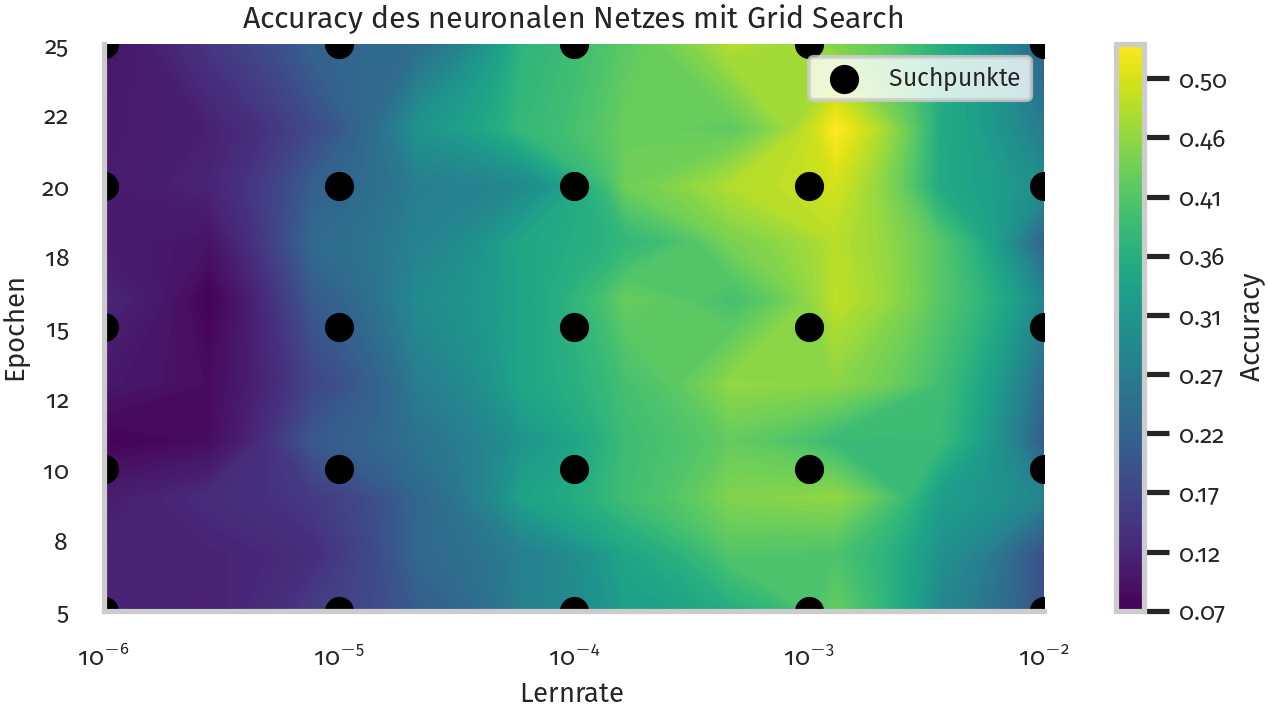

In [109]:
# build a 2D grid of lr x epochs and reshape val_acc into that grid for contourf
lr_vals = np.sort(df_hidden["lr"].unique())
epoch_vals = np.sort(df_hidden["epochs"].unique())

Z = df_hidden.pivot(index="epochs", columns="lr", values="val_acc").reindex(index=epoch_vals, columns=lr_vals)
X, Y = np.meshgrid(lr_vals, epoch_vals)

plt.figure(constrained_layout=True)
cs = plt.contourf(X, Y, Z.values, levels=HIDDEN_TRIALS, cmap="viridis")
plt.xscale("log")
plt.xlabel("Lernrate")
plt.ylabel("Epochen")
plt.title("Accuracy des neuronalen Netzes mit Grid Search")

cbar = plt.colorbar(cs, label="Accuracy")
cbar.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))

plt.scatter(df_grid["lr"], df_grid["epochs"], color="black", label="Suchpunkte")

plt.legend()
plt.show()

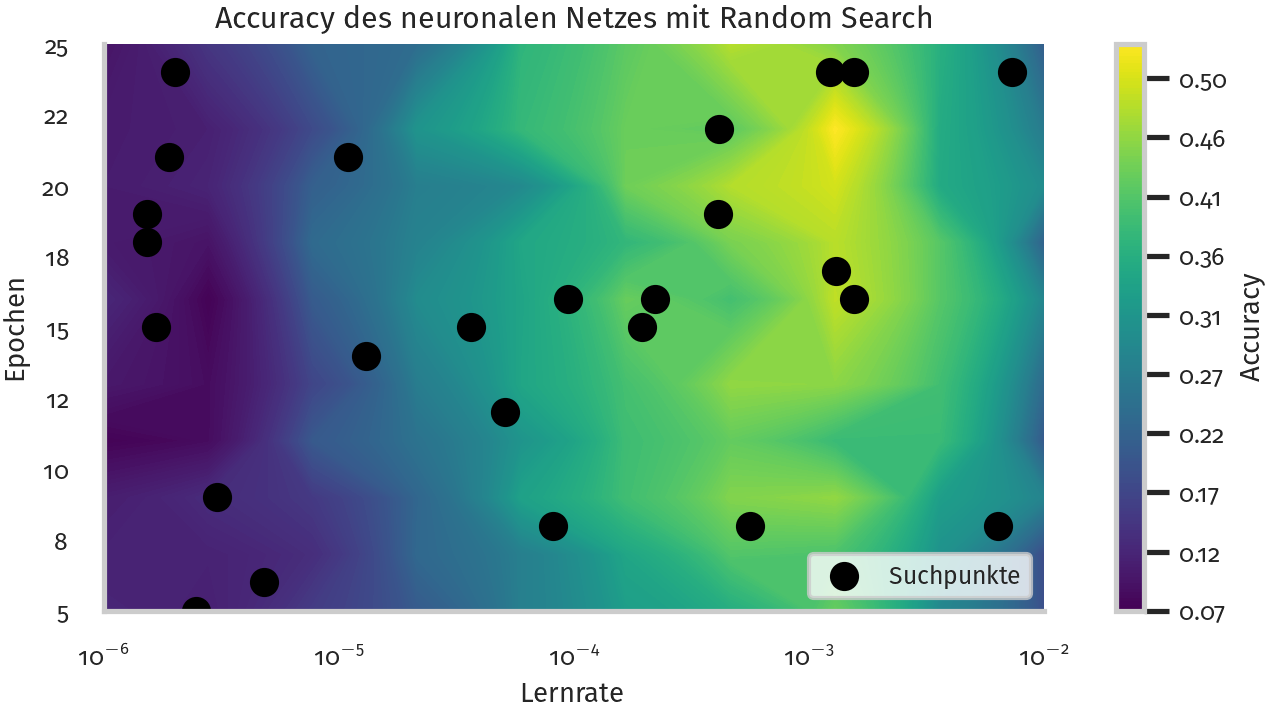

In [110]:
lr_vals = np.sort(df_hidden["lr"].unique())
epoch_vals = np.sort(df_hidden["epochs"].unique())

Z = df_hidden.pivot(index="epochs", columns="lr", values="val_acc").reindex(index=epoch_vals, columns=lr_vals)
X, Y = np.meshgrid(lr_vals, epoch_vals)

plt.figure(constrained_layout=True)
cs = plt.contourf(X, Y, Z.values, levels=HIDDEN_TRIALS, cmap="viridis")
plt.xscale("log")
plt.xlabel("Lernrate")
plt.ylabel("Epochen")
plt.title("Accuracy des neuronalen Netzes mit Random Search")

cbar = plt.colorbar(cs, label="Accuracy")
cbar.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))

plt.scatter(df_random["lr"], df_random["epochs"], color="black", label="Suchpunkte")

plt.legend()
plt.show()

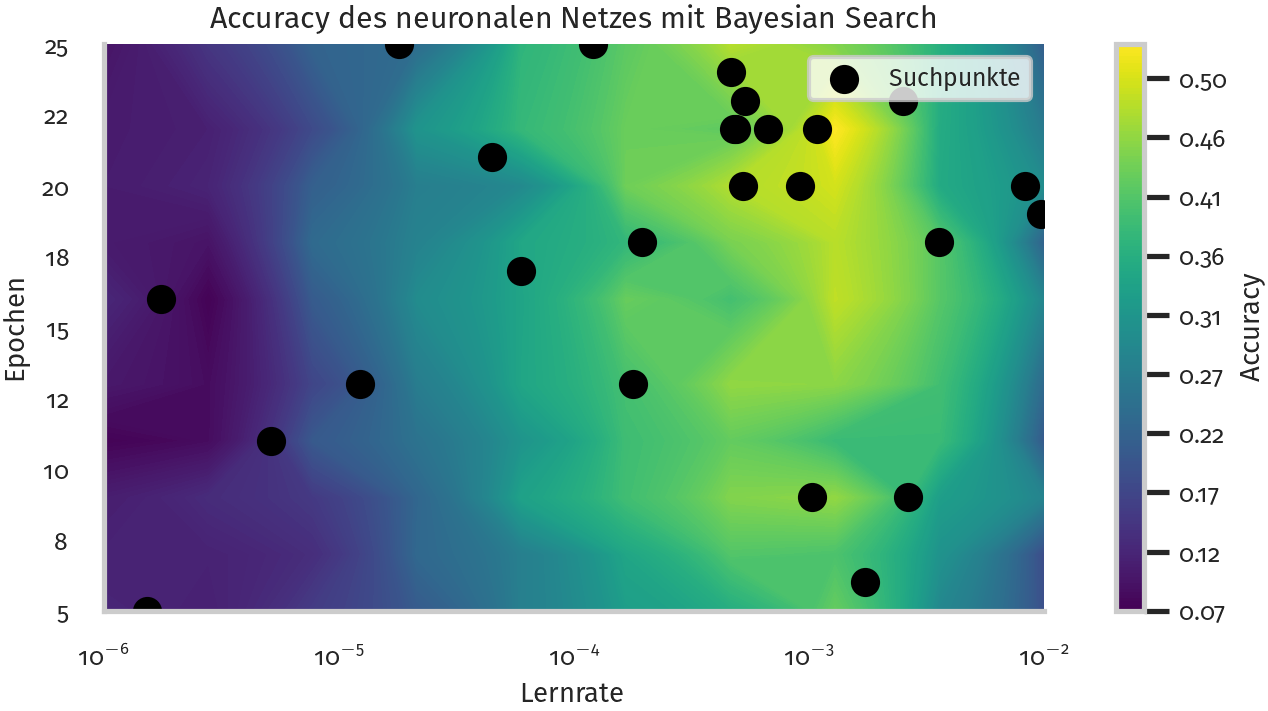

In [111]:
# build a 2D grid of lr x epochs and reshape val_acc into that grid for contourf
lr_vals = np.sort(df_hidden["lr"].unique())
epoch_vals = np.sort(df_hidden["epochs"].unique())

Z = df_hidden.pivot(index="epochs", columns="lr", values="val_acc").reindex(index=epoch_vals, columns=lr_vals)
X, Y = np.meshgrid(lr_vals, epoch_vals)

plt.figure(constrained_layout=True)
cs = plt.contourf(X, Y, Z.values, levels=HIDDEN_TRIALS, cmap="viridis")
plt.xscale("log")
plt.xlabel("Lernrate")
plt.ylabel("Epochen")
plt.title("Accuracy des neuronalen Netzes mit Bayesian Search")

cbar = plt.colorbar(cs, label="Accuracy")
cbar.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))

plt.scatter(df_bayesian["lr"], df_bayesian["epochs"], color="black", label="Suchpunkte")

plt.legend()
plt.show()

In [121]:
top_10_percent = df_hidden["val_acc"].max() * 0.9
print(f"90% of validation accuracy in hidden grid search: {top_10_percent:.4f}")

90% of validation accuracy in hidden grid search: 0.4770


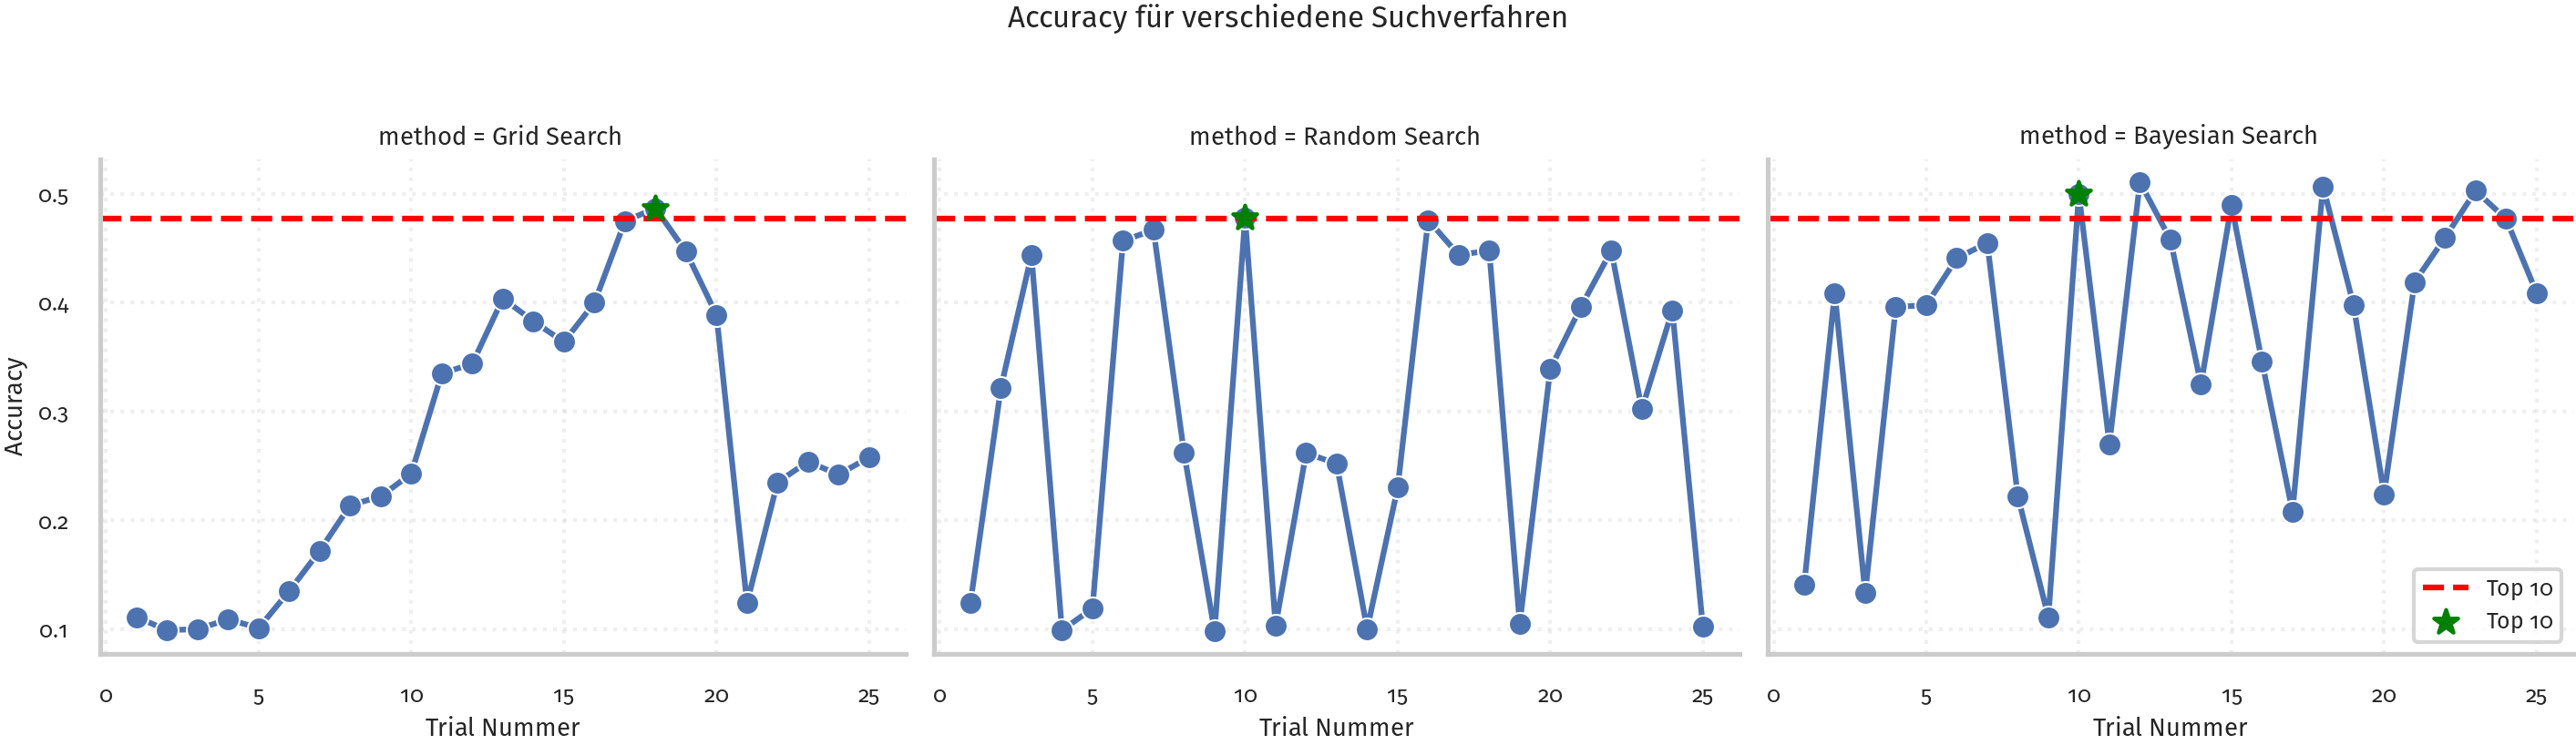

In [126]:
df_grid["method"] = "Grid Search"
df_random["method"] = "Random Search"
df_bayesian["method"] = "Bayesian Search"

df_all = pd.concat([df_grid, df_random, df_bayesian], ignore_index=True)

# Create a FacetGrid with one column per method
g = sns.relplot(
    data=df_all,
    x="counter",
    y="val_acc",
    col="method",
    kind="line",
    marker="o",
    height=4,
    aspect=1.2,
    facet_kws={"sharey": True, "sharex": True}
)

# Add horizontal line for top 5% and mark the first trial that reaches it
for ax, method in zip(g.axes.flat, df_all["method"].unique()):
    ax.axhline(top_10_percent, color="red", linestyle="--", label="Top 10%")

    # Find first trial where threshold is reached
    method_df = df_all[df_all["method"] == method]
    above_threshold = method_df[method_df["val_acc"] >= top_10_percent]
    if not above_threshold.empty:
        first_trial = above_threshold["counter"].iloc[0]
        first_val = above_threshold["val_acc"].iloc[0]
        # ax.axvline(first_trial, color="green", linestyle=":", label="Reached Top 5%")
        ax.scatter(first_trial, first_val, color="green", s=100, zorder=5, marker="*", label=f"Top 10% erreicht")

    ax.set_xlabel("Trial Nummer")
    ax.set_ylabel("Accuracy")

g.fig.suptitle("Accuracy für verschiedene Suchverfahren", y=1.05)
plt.legend()
plt.tight_layout()
plt.show()
